importar datos desde el DATASET y el libro de codigos que nos ayudará a limpiar variables.

In [171]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'dataset2.dta'
excel_file_path = 'Libro_de_codigos_Base_de_datos_Casen_2022(18marzo2024)(1).xlsx'
data = pd.read_stata(file_path, convert_categoricals=False)
data.shape

C:\Users\Seba\AppData\Local\Temp\ipykernel_2444\2241037780.py:12: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data = pd.read_stata(file_path, convert_categoricals=False)


(202231, 918)

eliminamos las filas con valores nulos o "0" en la variable dependiente

In [172]:
print("cantidad de datos antes del drop: ", data.shape[0])
data = data.dropna(subset=['ytrabajocor'])
print("cantidad de datos despues del drop: ", data.shape[0])
data.shape

cantidad de datos antes del drop:  202231
cantidad de datos despues del drop:  88976


(88976, 918)

# Limpieza de variables

Eliminacion de columnas con valores nulos mayor al 60%


In [173]:
umbral_nulos = 0.6
data = data.dropna(thresh=len(data) * (1 - umbral_nulos), axis=1)
data.shape

(88976, 483)

Eliminar columnas con tipo 'Timestamp' y tipo string

In [174]:
data = data.select_dtypes(exclude=['datetime', 'object'])
data.shape

(88976, 449)

Definición y eliminación de lista de variables personalizadas a eliminar

In [175]:
# Lista de variables personalizadas a eliminar
variables_limpieza = ['v27a', 'v27b', 'v28', 'v29a','v13_propia', 'v13_arrendada', 'v13_cedida', 'v13b_1', 'v13b_2', 'v13b_3', 'v13b_4', 'v13b_5', 'v13b_6', 'v13b_7','asal','h5_1a', 'h5_1b', 'h5_20', 'h5_2', 'n_nucleos', 'nucleo','r8a', 'r8b', 'r8c', 'r8d', 'r8e', 'r8f', 'r8g', 'r8h', 'r9a','v18','expr','expr_osig','varstrat','varunit','os_presente','e6a_asiste','e6a_no_asiste']  
limpieza_Y = pd.read_excel(excel_file_path, sheet_name='Y', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_Cepal = pd.read_excel(excel_file_path, sheet_name='Ing Cepal', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_MDSF = pd.read_excel(excel_file_path, sheet_name='Ing MDSF', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_HdR = pd.read_excel(excel_file_path, sheet_name='HdR', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_PM = pd.read_excel(excel_file_path, sheet_name='PM', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_S = pd.read_excel(excel_file_path, sheet_name='S', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_R = pd.read_excel(excel_file_path, sheet_name='R', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()
limpieza_H = pd.read_excel(excel_file_path, sheet_name='H', usecols=[1], skiprows=3).iloc[:, 0].dropna().tolist()

variables_limpieza += limpieza_H + limpieza_Y + limpieza_Cepal + limpieza_MDSF + limpieza_HdR + limpieza_PM + limpieza_S + limpieza_R
variables_mantener = ['sexo', 'ecivil', 'h7a', 'h7b', 'h7c', 'h7d', 'h7e', 'h7f','edad','s13', 's16', 's28', 's27a', 's34a', 's34c','ytrabajocor', 'region','area']

for variable in variables_mantener:
    variables_limpieza.remove(variable)

# Eliminar variables personalizadas
data = data.drop(columns=variables_limpieza, errors='ignore')
data.shape

(88976, 131)

In [176]:
# Eliminar filas con valores atípicos basados en el rango intercuartílico
Q1 = data.quantile(0.05)
Q3 = data.quantile(0.95)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

(45770, 131)

reemplazamos los datos con valores NAN (vacios) con el promedio de los

In [177]:
data = data.fillna(data.mean())
data.shape

(45770, 131)

se normalizan los datos con valores entre 0 y 1

In [178]:
# Normalización de datos
ss = MinMaxScaler()
data = pd.DataFrame(ss.fit_transform(data), columns=data.columns)

    X = data_scaled.drop(columns=['ytrabajocor']): Esto crea una nueva DataFrame X que contiene todas las columnas de data_scaled excepto ytrabajocor.
    
    y = data_scaled['ytrabajocor']: Esto crea una Serie y que contiene solo la columna ytrabajocor de data_scaled.

In [179]:
# Separar variables dependientes e independientes
X = data.drop(columns=['ytrabajocor'])
y = data['ytrabajocor']

                            OLS Regression Results                            
Dep. Variable:            ytrabajocor   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 4.679e+04
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        01:46:51   Log-Likelihood:                 82368.
No. Observations:               45770   AIC:                        -1.647e+05
Df Residuals:                   45761   BIC:                        -1.646e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      4.790      0.0

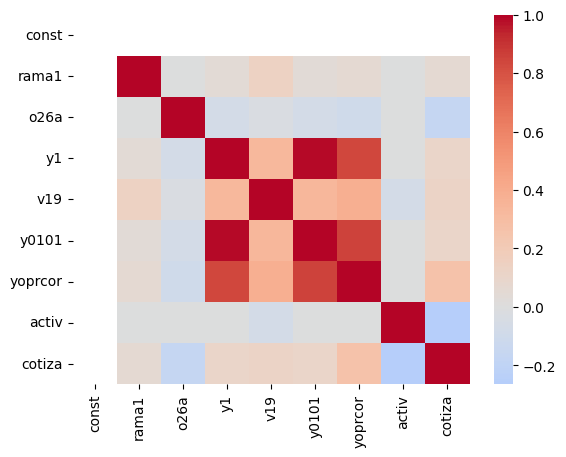

In [180]:
# Forward Feature Selection
selector_forward = SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='forward', scoring='r2')
selector_forward.fit(X, y)

# Transform data
X_selected_forward = selector_forward.transform(X)

# Add constant for regression
X_selected_forward = sm.add_constant(X_selected_forward)

# Fit the model
model_forward = sm.OLS(y, X_selected_forward).fit()

# Print model summary
print(model_forward.summary())

# Visualize the correlation matrix of selected features
selected_features_forward = X.columns[selector_forward.get_support()]
X_train_forward_df = pd.DataFrame(X_selected_forward, columns=['const'] + list(selected_features_forward))
sns.heatmap(X_train_forward_df.corr(), annot=False, cmap='coolwarm', center=0)
plt.show()

In [181]:
# Obtener las características seleccionadas
selected_features_forward = X.columns[selector_forward.support_]

# Imprimir las características seleccionadas
print("Variables seleccionadas (hacia adelante):", selected_features_forward)


Variables seleccionadas (hacia adelante): Index(['rama1', 'o26a', 'y1', 'v19', 'y0101', 'yoprcor', 'activ', 'cotiza'], dtype='object')
